This notebook demonstrates Kausal framework on Reaction-Diffusion (in 2D spatial dimension) dynamics. 

> __NOTE__: If you have not already done so, run through the notebook on `coupled_rossler` to get a sense of the overall workflow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from kausal.generator import reaction_diffusion_2d
from kausal.koopman import Kausal
from kausal import stats


# 1. Generate dynamics 
This time we use explicit coupling between reaction-diffusion equation.

$$
\frac{\partial u}{\partial t} = D_u \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) - u (u - a)(u - 1) + \beta v,
$$

$$
\frac{\partial v}{\partial t} = D_v \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) - v (v - b)(v - 1) + \gamma u.
$$

With coupling terms, and the following conditions for causal direction: if $\beta = 0$, $u \rightarrow v$ ; else if $\gamma = 0$, $v \rightarrow u$.

__Here, we use $\gamma = 0$, with the causal direction $v \rightarrow u$.__

In [3]:
# Spatial domain
Lx, Ly = 1.0, 1.0
Nx, Ny = 16, 16
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
X, Y = torch.meshgrid(
    torch.linspace(0, Lx, Nx), 
    torch.linspace(0, Ly, Ny), 
    indexing="ij"
)

# Time span
t0, t1 = 0.0, 10.0
dt = 0.001 

# Parameters
D_u, D_v = 0.1, 0.1  # Diffusion coefficients
a, b = 0.3, 0.3  # Reaction parameters

# Stability constraint for time step
max_dt = min(dx**2 / (2 * D_u), dy**2 / (2 * D_u))
dt = min(dt, max_dt)
steps = int((t1 - t0) / dt)
n_train = int(0.8 * steps)

# Initial conditions
u_init = a + 0.1 * torch.exp(-50 * ((X - 0.5) ** 2 + (Y - 0.5) ** 2))  # Near a
v_init = b + 0.1 * torch.exp(-50 * ((X - 0.5) ** 2 + (Y - 0.5) ** 2))  # Near b
initial_state = torch.cat([u_init.ravel(), v_init.ravel()])

# Coupling coefficients
beta, gamma = 10.0, 0.0  # gamma = 0 (v --> u), beta = 0 (u --> v)
params = (D_u, D_v, a, b, beta, gamma, Nx, Ny, dx, dy)


In [4]:
# Integration
solver = torchdiffeq.odeint

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: reaction_diffusion_2d(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method='dopri5',
        options={'max_num_steps': 100000}
    )
    return t, solution

t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract solutions for u and v
omega_1 = solution[:, :Nx * Ny].T.reshape((1, Nx, Ny, steps)) # U, True effect variables
omega_2 = solution[:, Nx * Ny:].T.reshape((1, Nx, Ny, steps)) # V, True cause variables


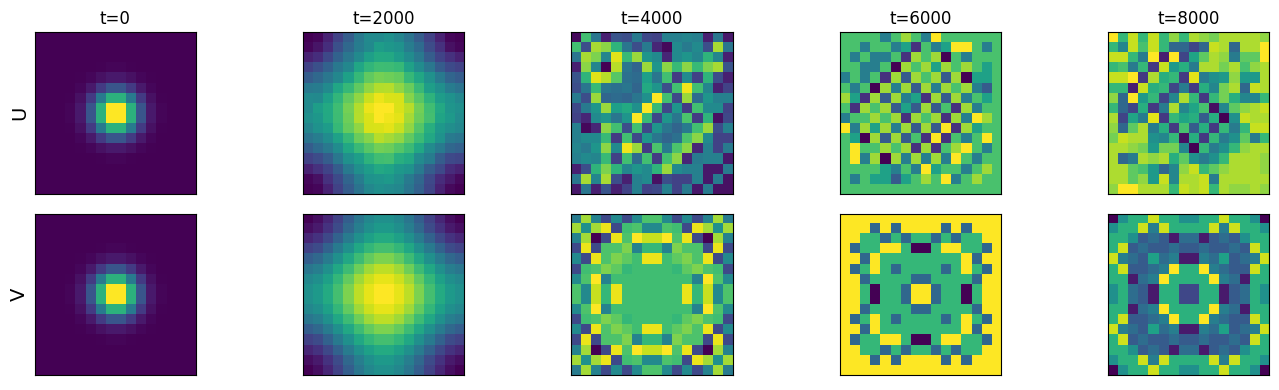

In [5]:
# Plot
n_plot = 5
n_skip = steps // n_plot
f, ax = plt.subplots(2, n_plot, figsize=(14,4))

for i in range(n_plot):
    ax[0,i].imshow(omega_1[0, :, :, ::n_skip][:, :, i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].set_title(f't={i*n_skip}')
    
    ax[1,i].imshow(omega_2[0, :, :, ::n_skip][:, :, i])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

ax[0,0].set_ylabel('U', fontsize=14)
ax[1,0].set_ylabel('V', fontsize=14)
plt.tight_layout()
plt.show();


# 2. Causal Koopman

### 2a. Causal dependence with increasing shifts

In [6]:
# Initialize Kausal object, where we can pass in the cause-effect variables to be analyzed

## Test C --> E (true causal direction)
causal_koopman = Kausal(
    cause = omega_2,
    effect = omega_1,
)

## Test E --> C (false causal direction)
noncausal_koopman = Kausal(
    cause = omega_1,
    effect = omega_2
)


In [7]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)

## 1. Causal effect
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 2. Non-causal effect
non_causal_effect = noncausal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 3. Hypothesis testing the causal relationship
_, pval = stats.hypothesis_testing(
    causal_effect = causal_effect,
    non_causal_effect = non_causal_effect
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.26s/it]


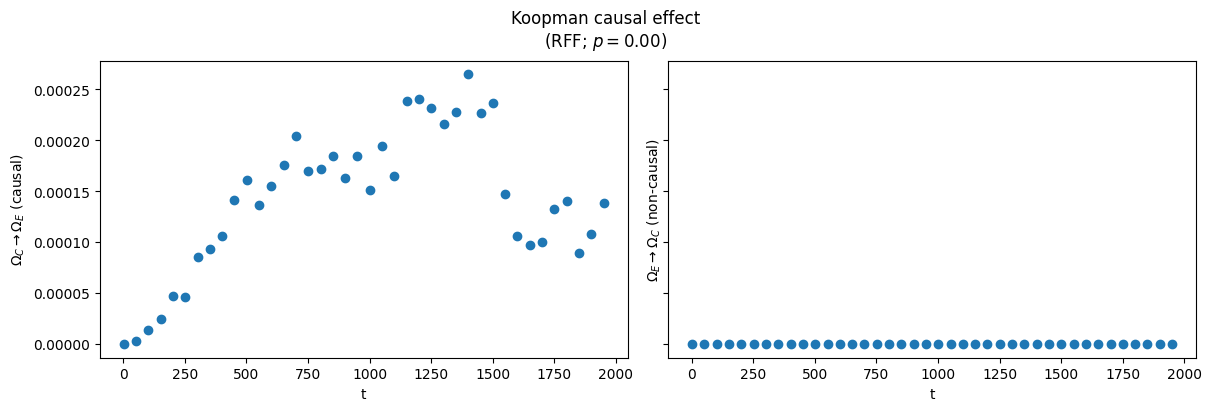

In [8]:
# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, causal_effect)
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].scatter(time_shifts, non_causal_effect)
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

f.suptitle(f'Koopman causal effect\n(RFF; $p = {pval:.2f}$)')
plt.show();


# 3. Deep Causal Koopman

### 3a. Causal dependence with increasing shifts

Now, we use neural network (encoder-decoder __CNN__) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the observables. We perform similar causal analysis as above!

In [9]:
# Initialize Kausal object, where we now specify DL-based observable functions.
from kausal.observables import CNNFeatures

# Specify hyperparameters
hidden_channels = [16, 32, 64, 128]

## Test C --> E (true causal direction)
causal_koopman = Kausal(
    marginal_observable = CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
    joint_observable = CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
    cause = omega_2,
    effect = omega_1,
)

## Test E --> C (false causal direction)
noncausal_koopman = Kausal(
    marginal_observable = CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
    joint_observable = CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
    cause = omega_1,
    effect = omega_2
)


In [10]:
# We first have to fit/train the observable functions
lr = 1e-4
epochs = 50
batch_size = 32

# 1. Causal direction
marginal_loss_ce, joint_loss_ce = causal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = batch_size
)

# 2. Non-causal direction
marginal_loss_ec, joint_loss_ec = noncausal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = batch_size
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.10it/s]


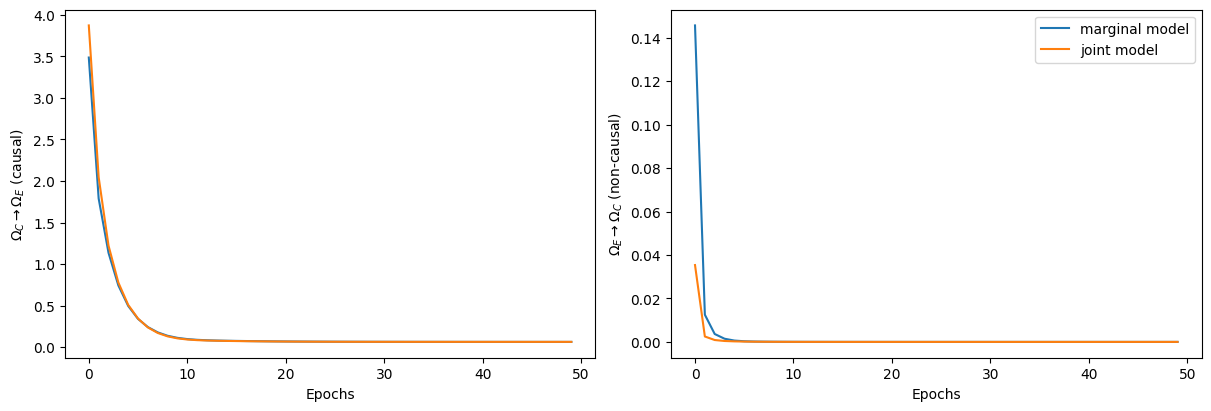

In [11]:
# Plot training losses
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax[0].plot(marginal_loss_ce, label='marginal model')
ax[0].plot(joint_loss_ce, label='joint model')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].plot(marginal_loss_ec, label='marginal model')
ax[1].plot(joint_loss_ec, label='joint model')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

plt.legend()
plt.show();


### 3a. Causal dependence with increasing shifts

In [12]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)

## 1. Causal effect
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 2. Non-causal effect
non_causal_effect = noncausal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 3. Hypothesis testing the causal relationship
_, pval = stats.hypothesis_testing(
    causal_effect = causal_effect,
    non_causal_effect = non_causal_effect
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:14<00:00,  2.74it/s]


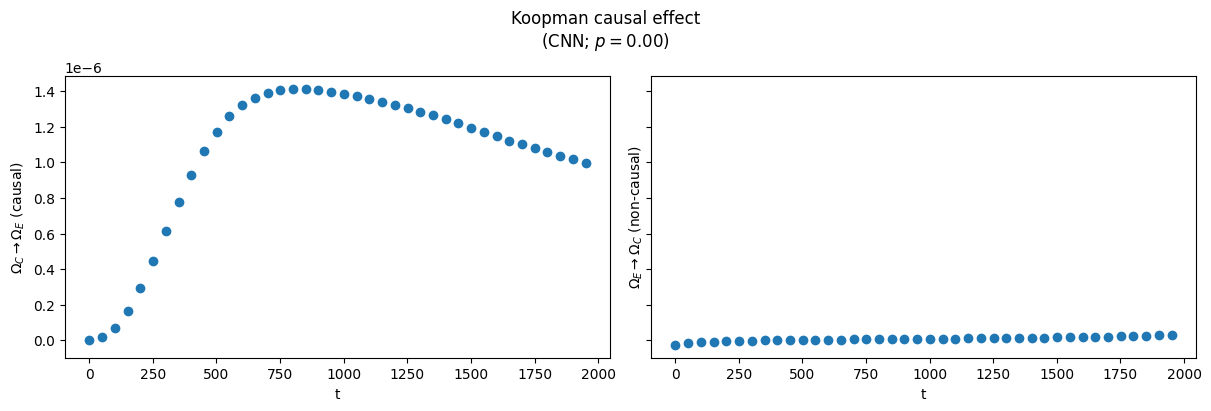

In [13]:
# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, causal_effect)
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].scatter(time_shifts, non_causal_effect)
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

f.suptitle(f'Koopman causal effect\n(CNN; $p = {pval:.2f}$)')
plt.show();
